In [1]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix, isspmatrix

import matplotlib.pyplot as plt
import scanpy.external as sce

from datetime import datetime

In [2]:
print("Scanpy version: ", sc.__version__)
print("Pandas version: ", pd.__version__)
anndata2ri.activate()
time_start = datetime.now()
print(time_start)

Scanpy version:  1.9.3
Pandas version:  2.0.3
2023-11-02 03:47:31.483319


In [3]:
import sys
sys.path.append('..')

from src.configs import config
%load_ext autoreload
%autoreload 2

In [4]:
%load_ext rpy2.ipython

# Ignore R warning messages
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
#Note: this can be commented out to get more verbose R output
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=120)

# Read Counts Data

## E-MATB Dataset

In [5]:
data = pd.read_csv(config.PATHS.EMATB/'iNeuron_all_cells_UMIcouts.csv')
data.index = pd.Index(data.iloc[:, 0])
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data = data.astype(pd.SparseDtype(int, 0))
data.sparse.density

0.10552045042553092

In [6]:
ann_data = sc.AnnData(X=data.T)
ann_data.obs.index = data.columns
ann_data.var.index = data.index

In [7]:
# Add Barcode and Gene annotation
meta = pd.read_csv(config.PATHS.EMATB/'iNeuron_all_cells_metadata.csv')
meta.drop(['Unnamed: 0'], axis=1, inplace=True)
meta.head()

,cell_id,timepoint,line,10X_date,clusters,tSNE_1,tSNE_2
0,AAACCCAAGATAGCAT.1.d35_h9_200818,d35,h9,200818,C1,-43.575724,37.239965
1,AAACCCAAGCCTGAGA.1.d14_sc102a1_200920,d14,sc102a1,200920,C7,48.554482,54.936585
2,AAACCCAAGGCTGAAC.1.d35_h9_200818,d35,h9,200818,C2,-60.552954,-2.594599
3,AAACCCAAGTGCAACG.1.d35b2_bmrna_200908,d35b2,bmrna,200908,C7,47.740916,43.250069
4,AAACCCACACAGTACT.1.d35_h9_200818,d35,h9,200818,C2,-73.776997,3.398855


### Check for non-matching barcodes

In [8]:
# Set the index as the cell barcode
meta = meta.set_index('cell_id').copy()
# then order the meta data to match adata
metaOrd = meta.reindex(ann_data.obs.index)
print(len(metaOrd))

#Save to filter later
strange_barcodes = set(ann_data.obs.index).difference(set(meta.index))
print(metaOrd[metaOrd.index.isin(strange_barcodes) == True])

ann_data.obs = metaOrd
keep_cells = ann_data.obs.drop(strange_barcodes).index
#Filter out strange barcodes
ann_data = ann_data[ann_data.obs_names.isin(keep_cells)]
ann_data

36034
Empty DataFrame
Columns: [timepoint, line, 10X_date, clusters, tSNE_1, tSNE_2]
Index: []


View of AnnData object with n_obs × n_vars = 36034 × 23454
    obs: 'timepoint', 'line', '10X_date', 'clusters', 'tSNE_1', 'tSNE_2'

there is no mismatched barcodes

In [9]:
# check on the sparse matrix 
if isspmatrix(ann_data.X) == False:
    ann_data.X = csr_matrix(ann_data.X)
    print('Converted adata.X to', type(ann_data.X))

In [10]:
ann_data.obs['cluster'] = ann_data.obs['clusters'].copy()
#adata.obs.dtypes
ann_data.obs.head()

/tmp/ipykernel_536262/2602906112.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ann_data.obs['cluster'] = ann_data.obs['clusters'].copy()


,timepoint,line,10X_date,clusters,tSNE_1,tSNE_2,cluster
AAACCTGAGACCTAGG-4.d5_409b2_171212,d5,409b2,171212,C8,-89.187002,19.220198,C8
AAACCTGAGTCCGTAT-4.d5_409b2_171212,d5,409b2,171212,C5,48.413219,-12.483613,C5
AAACCTGGTATCTGCA-4.d5_409b2_171212,d5,409b2,171212,C5,86.033093,-7.297135,C5
AAACCTGTCATAAAGG-4.d5_409b2_171212,d5,409b2,171212,C8,-99.750682,15.862280,C8
AAACCTGTCGTTGCCT-4.d5_409b2_171212,d5,409b2,171212,C7,34.884410,62.724772,C7


In [11]:
ann_data.obs['timepoint_mapped'] = ann_data.obs['timepoint'].apply(
    lambda x: config.TIMEPOINT_MAP[x])
if config.PROTO.DATASETS.BATCH_FROM_TIMEPOINT:
    ann_data.obs['batch'] = ann_data.obs['timepoint'].apply(
        lambda x: 'b{}'.format(config.BATCH_MAP[x]))
else:
    ann_data.obs['batch'] = [ 
        idx.split('_')[-1] for idx in ann_data.obs.index ]
    ann_data.obs.batch += '_b' + ann_data.obs.timepoint.apply(lambda x: str(config.BATCH_MAP[x]))

ann_data.obs['dataset'] = 'EMATB'

In [12]:
tab = pd.crosstab(
    ann_data.obs['timepoint_mapped'], ann_data.obs['cluster'])
tab

cluster,C1,C2,C3,C4,C5,C6,C7,C8
timepoint_mapped,,,,,,,,
5,316,220,429,138,962,484,791,131
14,763,467,924,129,1752,458,910,317
28,1323,650,1060,127,2309,887,1457,203
35,3039,3750,3979,330,2227,1397,2557,1548


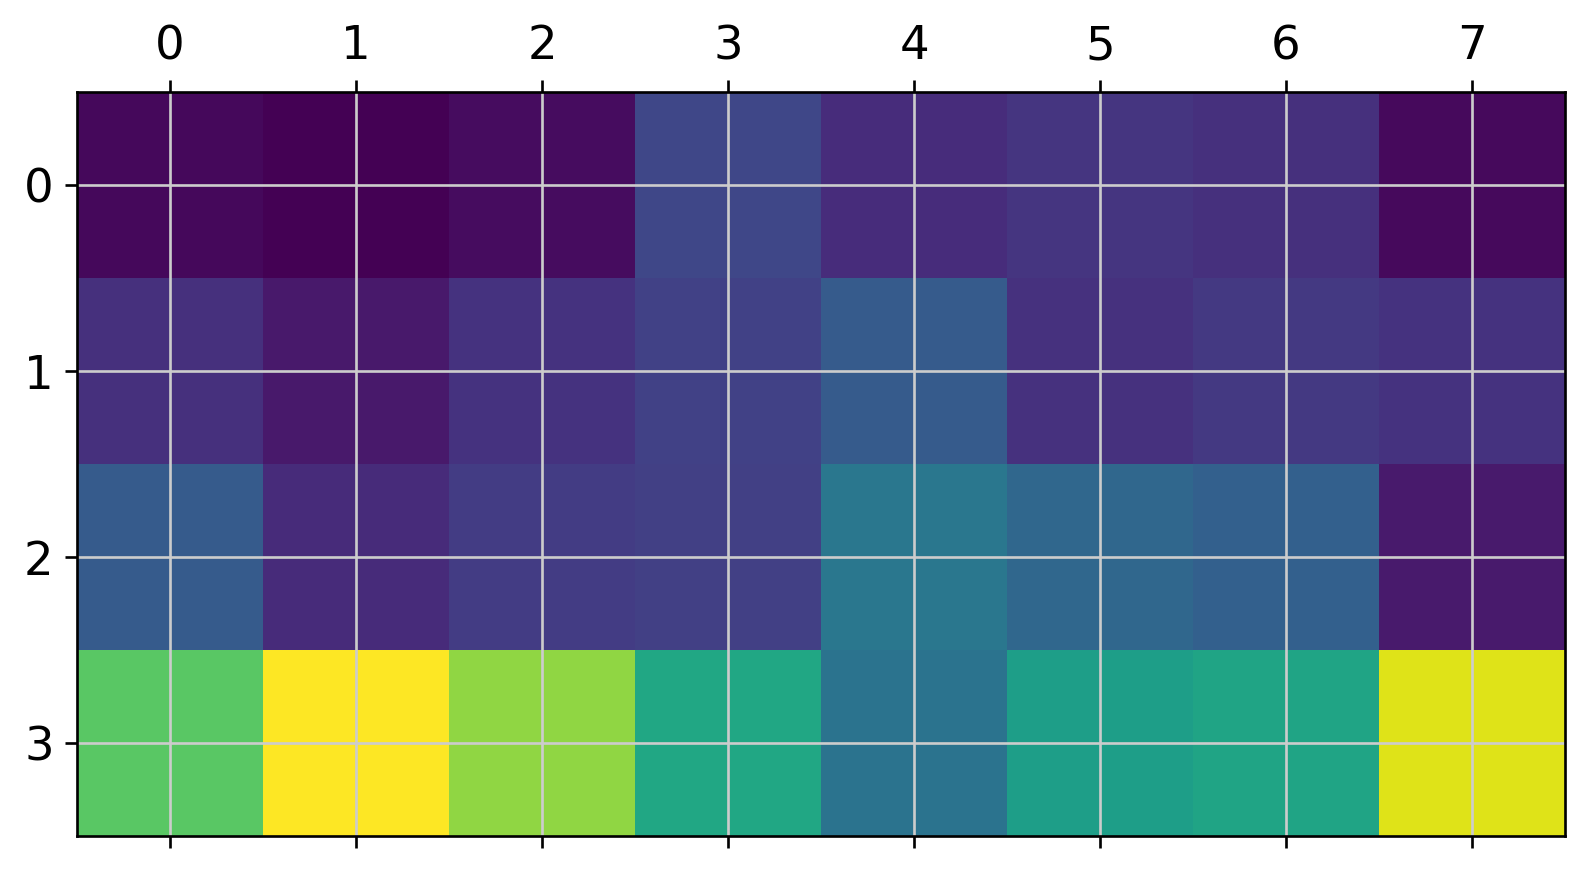

In [13]:
plt.matshow(tab.values / tab.sum(0).values[np.newaxis])

In [14]:
ann_data.write(config.PATHS.CSV/'EMATB.h5ad')
print(datetime.now() - time_start)

0:06:46.157764


## Mendeley Dataset

In [15]:
import scipy.io
sp_matrix = scipy.io.mmread(config.PATHS.MENDELEY/"counts.mtx")
sp_matrix = csr_matrix(sp_matrix)

meta = pd.read_csv(config.PATHS.MENDELEY/"meta.tsv", sep='\t')
features = pd.read_csv(
    config.PATHS.MENDELEY/"features.tsv", sep='\t', names=['features'])

In [16]:
adata = sc.AnnData(X=sp_matrix.T)
adata.obs = meta
adata.var.index = features.iloc[:, 0].values
adata

AnnData object with n_obs × n_vars = 3866 × 17546
    obs: 'nGene', 'nUMI', 'sample', 'batch', 'timepoint', 'line', 'percent.mito', 'percent.ribo', 'integrated_snn_res.0.3_merged', 'alt_cell_name', 'nVector', 'expr_exoNgn2'

In [17]:
timecourse = config.PATHS.MENDELEY/'..'/'timecourse'
sp_matrix = scipy.io.mmread(timecourse/"counts.mtx")
sp_matrix = csr_matrix(sp_matrix)

meta = pd.read_csv(timecourse/"meta.tsv", sep='\t')
features = pd.read_csv(
    timecourse/"features.tsv", sep='\t', names=['features'])

In [18]:
bdata = sc.AnnData(X=sp_matrix.T)
bdata.obs = meta
bdata.var.index = features.iloc[:, 0].values
bdata

AnnData object with n_obs × n_vars = 29554 × 17546
    obs: 'nGene', 'nUMI', 'sample', 'batch', 'timepoint', 'line', 'percent.mito', 'percent.ribo', 'seurat_clusters', 'pseudocell_group', 'alt_cell_name', 'pt_dm'

In [19]:
doublecated = adata.obs.index.intersection(bdata.obs.index)
adata = adata[~adata.obs_names.isin(doublecated)]
adata

View of AnnData object with n_obs × n_vars = 2876 × 17546
    obs: 'nGene', 'nUMI', 'sample', 'batch', 'timepoint', 'line', 'percent.mito', 'percent.ribo', 'integrated_snn_res.0.3_merged', 'alt_cell_name', 'nVector', 'expr_exoNgn2'

In [20]:
ann_data = sc.concat([adata, bdata])

In [21]:
ann_data.obs['timepoint_mapped'] = ann_data.obs['timepoint'].apply(
    lambda x: config.TIMEPOINT_MAP[x])
ann_data.obs['batch'] = ann_data.obs['batch'].apply(
    lambda x: 'b{}'.format(x))
ann_data.obs['cluster'] = ann_data.obs['batch']
ann_data.obs['dataset'] = 'MEDELEY'
ann_data.obs.head()

,nGene,nUMI,sample,batch,timepoint,line,percent.mito,percent.ribo,alt_cell_name,timepoint_mapped,cluster,dataset
AAACCTGAGAGTCTGG-1,2080,5207,180410_d35,b180410,w5,409b2_clone,0.018053,0,AAACCTGAGAGTCTGG-180410_d35,35,b180410,MEDELEY
AAACCTGAGTGTGGCA-1,1400,2737,180410_d35,b180410,w5,sc102a1,0.081476,0,AAACCTGAGTGTGGCA-180410_d35,35,b180410,MEDELEY
AAACCTGCAATGTTGC-1,1229,2424,180410_d35,b180410,w5,409b2_clone,0.012789,0,AAACCTGCAATGTTGC-180410_d35,35,b180410,MEDELEY
AAACCTGCAGGTCGTC-1,3969,14072,180410_d35,b180410,w5,409b2_clone,0.012081,0,AAACCTGCAGGTCGTC-180410_d35,35,b180410,MEDELEY
AAACCTGGTTTGTTGG-1,3286,10665,180410_d35,b180410,w5,sc102a1,0.054571,0,AAACCTGGTTTGTTGG-180410_d35,35,b180410,MEDELEY


In [22]:
ann_data.write(config.PATHS.CSV/'MENDELEY.h5ad')
print(datetime.now() - time_start)

0:08:25.764202


# Open Dataset

In [23]:
input_file = str(config.PATHS.OPEN/'raw_counts_mat.rdata')

In [24]:
%%R -i input_file -o raw_counts_mat

load(input_file)
class(raw_counts_mat)

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"


In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [25]:
%%R -o genes -o cells

#Store names as vectors to set as indexes later
genes <- rownames(raw_counts_mat)
cells <- colnames(raw_counts_mat)

In [26]:
# We have the counts as sparse matrix
raw_counts_mat = raw_counts_mat.T
raw_counts_mat #Compressed Sparse Column format

<33986x35543 sparse matrix of type '<class 'numpy.float64'>'
	with 35635307 stored elements in Compressed Sparse Row format>

In [27]:
ann_data =  sc.AnnData(X=raw_counts_mat)
ann_data.obs.index = cells
ann_data.var.index = genes

In [28]:
# 4. Add Barcode and Gene annotation
meta = pd.read_csv(config.PATHS.OPEN/'cell_metadata.csv')
meta.head()

,Cell,Cluster,Subcluster,Donor,Layer,Gestation_week,Index,Library,Number_genes_detected,Number_UMI,Percentage_mitochondrial,S_phase_score,G2M_phase_score,Phase
0,TGCTAATACTGA,vRG,vRG_0,368,CP,17,N701,Plath,1366,2736,4.20,-0.11,-0.073,G1
1,TTCACGATTTTT,vRG,vRG_2,368,GZ,17,N702,Plath,3012,7318,1.87,0.83,0.350,S
2,CTGTCAGAATAA,vRG,vRG_2,368,GZ,17,N702,Plath,1597,3451,2.17,-0.13,-0.110,G1
3,CATAATATGTCA,vRG,vRG_0,368,GZ,17,N702,Plath,1551,2941,1.43,0.38,0.064,S
4,TGCCAATCCGTT,vRG,vRG_0,368,GZ,17,N702,Plath,1569,2769,1.81,-0.04,-0.170,G1


### Check for non-matching barcodes

In [29]:
# Set the index as the cell barcode
meta = meta.set_index('Cell').copy()
# then order the meta data to match adata
metaOrd = meta.reindex(ann_data.obs.index)

#Save to filter later
strange_barcodes = set(ann_data.obs.index).difference(set(meta.index))
metaOrd[metaOrd.index.isin(strange_barcodes) == True]

# Attach to obs
ann_data.obs = metaOrd.copy()
keep_cells = ann_data.obs.drop(strange_barcodes).index

# Filter out strange barcodes
ann_data = ann_data[ann_data.obs_names.isin(keep_cells)]

**Check that the matrix is sparse**

In [30]:
# Check on the sparse matrix 
if isspmatrix(ann_data.X) == False:
    ann_data.X = csr_matrix(ann_data.X)
    print('Converted adata.X to', type(ann_data.X))

In [31]:
ann_data.obs['line'] = ann_data.obs['Donor']
ann_data.obs.line = 'S_' + ann_data.obs.line.astype(
    'int64').astype('str')
ann_data.obs['cluster'] = ann_data.obs['Cluster']

ann_data.obs['timepoint'] = ann_data.obs['Gestation_week'].apply(
    lambda x: 'w{}'.format(int(x)))
ann_data.obs['timepoint_mapped'] = ann_data.obs['timepoint'].apply(
    lambda x: config.TIMEPOINT_MAP[x])

ann_data.obs['dataset'] = 'OPEN'
ann_data.obs.head()

/tmp/ipykernel_536262/204051031.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ann_data.obs['line'] = ann_data.obs['Donor']


,Cluster,Subcluster,Donor,Layer,Gestation_week,Index,Library,Number_genes_detected,Number_UMI,Percentage_mitochondrial,S_phase_score,G2M_phase_score,Phase,line,cluster,timepoint,timepoint_mapped,dataset
CGCCGTACGTTC,ExM,ExM_1,368.0,CP,17.0,N701,Plath,3056.0,9036.0,3.18,-0.0075,-0.12,G1,S_368,ExM,w17,119,OPEN
TCAGCGTGGACA,End,End_0,368.0,CP,17.0,N701,Plath,3144.0,7280.0,3.46,-0.0900,-0.18,G1,S_368,End,w17,119,OPEN
TATGCTTATGTC,ExM,ExM_1,368.0,CP,17.0,N701,Plath,2778.0,7908.0,3.63,-0.0290,-0.22,G1,S_368,ExM,w17,119,OPEN
TCAGCGTGGACT,End,End_3,368.0,CP,17.0,N701,Plath,2936.0,6687.0,3.14,-0.0850,-0.21,G1,S_368,End,w17,119,OPEN
GATTACCTTATA,ExM,ExM_1,368.0,CP,17.0,N701,Plath,2586.0,7111.0,4.21,-0.1200,-0.16,G1,S_368,ExM,w17,119,OPEN


<Axes: xlabel='Gestation_week'>

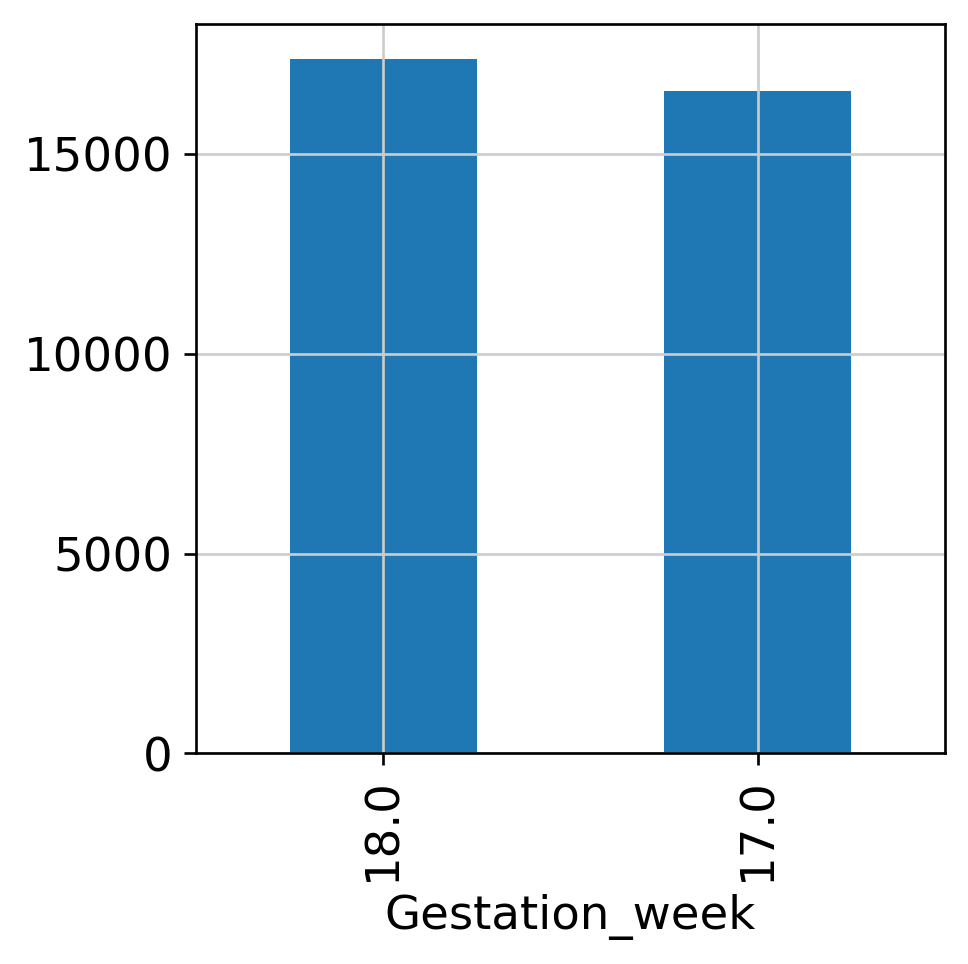

In [32]:
### Gestation week
ann_data.obs['Gestation_week'].value_counts()
ann_data.obs['Gestation_week'].value_counts().plot.bar()

In [33]:
ann_data.write(config.PATHS.CSV/'OPEN.h5ad')
print(datetime.now() - time_start)

0:08:39.308813
